## Setup

Load required packages

In [67]:
import pandas as pd
import io
import requests
import numpy as np
import random
import libpysal
import pysal
import pysal.lib
import gpytorch
import torch
import math

Read data

In [68]:
data = pd.read_csv("C:/Users/kklemmer/Documents/GitHub/spacegan/analysis/grid_aug_ex1.csv")
#Create ID column
#data["id"] = np.asarray(list(range(0,len(data["longitude"])))).reshape(-1,1)

In [69]:
data.head(3)

,id,y,z,latitude,longitude,fold1,fold2,fold3,fold4,fold5,fold6,fold7,fold8,fold9,fold10
0,1,-0.844504,1.370958,2.5,2.5,1,2,2,2,2,1,2,2,2,2
1,2,-0.832568,-0.564698,2.5,7.5,1,2,2,2,2,1,2,2,2,2
2,3,-0.793995,0.363128,2.5,12.5,1,0,2,2,2,1,2,2,2,2


In [70]:
test_data = data[data["fold2"]==2]

## Spatial Grid Expansion

In [71]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)

        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel(ard_num_dim=2,has_lengthscale=True), grid_size=grid_size, num_dims=2,
            ), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [72]:
def grid_expand(data,fact):
    
    #Create lon and lat groups (for the case that the test data splits our regular box in two separate training sets)
    lon_unique = data.longitude.unique() #Get unique lon/lat values
    inp = np.insert(np.diff(data.longitude.unique()),0,np.min(np.diff(data.longitude.unique()))) #Get differences at each step
    res = []
    k = 1
    for i in inp: #Loop over differences and assign new group if a gap is detected
        if i != np.min(inp):
            k = k+1
        else:
            k = k
        res += [k]

    d = {'longitude': lon_unique, 'group_lon': res} #Bind into a dataframe
    lon_group = pd.DataFrame(data=d)
    #Repeat for latitude
    lat_unique = data.latitude.unique()
    inp = np.insert(np.diff(data.latitude.unique()),0,np.min(np.diff(data.latitude.unique())))
    res = []
    k = 1
    for i in inp:
        if i != np.min(inp):
            k = k+1
        else:
            k = k
        res += [k]
    d = {'latitude': lat_unique, 'group_lat': res}
    lat_group = pd.DataFrame(data=d)
    #Merge with input data
    data = pd.merge(lon_group,data, how="right", on=["longitude"])
    data = pd.merge(lat_group,data, how="right", on=["latitude"])
    #Create dataset for storing the final results
    final_data = pd.DataFrame()
    
    for o in data.group_lat.unique():
        #Select group
        temp1_data = data[data["group_lat"]==o]
        for p in temp1_data.group_lon.unique():
            #Select group
            temp_data = temp1_data[temp1_data["group_lon"]==p]
            #Create new grid:
            #Copy column names from existing grid
            new_points = pd.DataFrame(columns=temp_data[["longitude","latitude"]].columns)
            #Expand longitude by factor `fact`
            dst = (temp_data[["longitude"]].max() - temp_data[["longitude"]].min()) / (len(temp_data.longitude.unique())-1)
            exp = float(dst/fact)
            x = []
            d = float(temp_data[["longitude"]].min())
            while d <= float(temp_data[["longitude"]].max()):
                x.append(d)    
                d = d + exp
            #Expand latitude by factor `fact`
            dst = (temp_data[["latitude"]].max() - temp_data[["latitude"]].min()) / (len(temp_data.latitude.unique())-1)
            exp = float(dst/fact)
            y = []
            d = float(temp_data[["latitude"]].min())
            while d <= float(temp_data[["latitude"]].max()):
                y.append(d)    
                d = d + exp
            #Bind new lat and lon values
            lon = x * len(y)
            lat = sorted(y*len(x))
            #Create new points dataframe
            new_points = pd.DataFrame({"longitude":lon,"latitude":lat})
            #Merge with existing dataframe
            new_data = pd.merge(new_points,data, how="left", on=["longitude","latitude"])
            #Create column to indicate whether observation is original or synthetic 
            new_data["synth"] = 0
            new_data.loc[new_data.id.isnull(), "synth"] = 1

            #Spatial operations:
            #Compute distance matrix of new grid
            dist = pysal.lib.cg.distance_matrix(np.array(new_data[["longitude","latitude"]]))
            #Extract and flatten 10 nearest distances
            k=10
            u_dist = np.unique(dist)
            k_min_dist = np.sort(u_dist.flatten())[:k]
            #Create KD tree
            kd = pysal.lib.cg.kdtree.KDTree(np.array(new_data[["longitude","latitude"]]))
            #Define neighbourhood (here Queen structure)
            w = pysal.lib.weights.distance.DistanceBand(kd, threshold=k_min_dist[2],binary=True,p=2) #Queen
            #Bind to existing data
            final_data = pd.concat([final_data, new_data])

    #Re-assign IDs
    final_data[["id"]] = np.asarray(list(range(0,len(final_data["id"])))).reshape(-1,1)
    #Delete helper columns
    final_data = final_data.drop(columns=["group_lat","group_lon"])
    #Return new dataframe
    return final_data

In [73]:
new_grid = grid_expand(test_data,2)

In [74]:
#Get train and test data
train = new_grid[new_grid["synth"]==0]
test = new_grid[new_grid["synth"]==1]
#Covert to pytorch tensor
train_x = torch.from_numpy(np.asarray(train[["longitude","latitude"]])).float()
train_y = torch.from_numpy(np.asarray(train[["y","z"]])).float()
test_x = torch.from_numpy(np.asarray(test[["longitude","latitude"]])).float()

In [75]:
#Initiate scalable GP
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel(ard_num_dim=2,has_lengthscale=True), grid_size=grid_size, num_dims=2,
            ), num_tasks=2, rank=1
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [76]:
#Train GP
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)
# Find optimal model hyperparameters
model.train()
likelihood.train()
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
n_iter = 150
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

Iter 1/150 - Loss: 353.187
Iter 2/150 - Loss: 347.025
Iter 3/150 - Loss: 340.020
Iter 4/150 - Loss: 335.144
Iter 5/150 - Loss: 330.540
Iter 6/150 - Loss: 329.295
Iter 7/150 - Loss: 321.308
Iter 8/150 - Loss: 314.563
Iter 9/150 - Loss: 316.065
Iter 10/150 - Loss: 313.376
Iter 11/150 - Loss: 311.975
Iter 12/150 - Loss: 304.339
Iter 13/150 - Loss: 299.544
Iter 14/150 - Loss: 296.404
Iter 15/150 - Loss: 292.767
Iter 16/150 - Loss: 291.026
Iter 17/150 - Loss: 286.271
Iter 18/150 - Loss: 278.046
Iter 19/150 - Loss: 278.317
Iter 20/150 - Loss: 269.691
Iter 21/150 - Loss: 271.069
Iter 22/150 - Loss: 267.126
Iter 23/150 - Loss: 261.515
Iter 24/150 - Loss: 257.549
Iter 25/150 - Loss: 251.967
Iter 26/150 - Loss: 250.509
Iter 27/150 - Loss: 242.895
Iter 28/150 - Loss: 238.483
Iter 29/150 - Loss: 235.378
Iter 30/150 - Loss: 233.065
Iter 31/150 - Loss: 230.394
Iter 32/150 - Loss: 222.954
Iter 33/150 - Loss: 221.157
Iter 34/150 - Loss: 214.655
Iter 35/150 - Loss: 216.488
Iter 36/150 - Loss: 207.246
I

In [77]:
# Set into eval mode
model.eval()
likelihood.eval()
# Make predictions
with torch.no_grad(), gpytorch.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    # Get mean
    mean = observed_pred.mean
    # Get lower and upper confidence bounds
    lower, upper = observed_pred.confidence_region()
#Convert results back to GP
test[["longitude","latitude"]] = test_x.numpy()
test[["y","z"]] = mean.numpy()     
#Create final dataframe
final_data = pd.concat([train, test])

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [78]:
final_data

,longitude,latitude,id,y,z,fold1,fold2,fold3,fold4,fold5,fold6,fold7,fold8,fold9,fold10,synth
0,2.5,2.5,0,-0.844504,1.370958,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,0
2,7.5,2.5,2,-0.832568,-0.564698,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,0
6,2.5,7.5,6,-0.832449,-0.306639,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,0
8,7.5,7.5,8,-0.845500,-1.781308,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,0
12,2.5,12.5,12,-0.794071,0.205999,1.0,2.0,2.0,2.0,2.0,1.0,0.0,2.0,2.0,2.0,0
14,7.5,12.5,14,-0.832475,-0.361057,1.0,2.0,2.0,2.0,2.0,1.0,0.0,2.0,2.0,2.0,0
18,2.5,17.5,18,-0.730823,-0.367235,1.0,2.0,2.0,2.0,2.0,1.0,0.0,2.0,2.0,2.0,0
20,7.5,17.5,20,-0.794082,0.185231,1.0,2.0,2.0,2.0,2.0,1.0,0.0,2.0,2.0,2.0,0
24,2.5,22.5,24,-0.641186,1.512707,1.0,2.0,2.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0,0
26,7.5,22.5,26,-0.730511,0.257921,1.0,2.0,2.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0,0


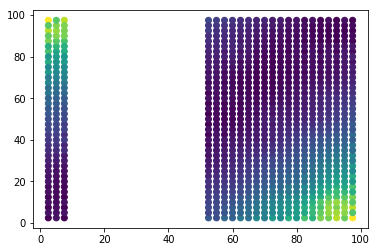

In [83]:
import matplotlib.pyplot as plt
plt.scatter(final_data["longitude"],final_data["latitude"],c=final_data["y"])

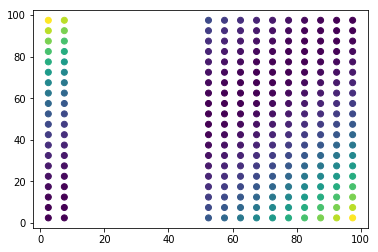

In [84]:
plt.scatter(test_data["longitude"],test_data["latitude"],c=test_data["y"])